In [2]:
using PyPlot

In [5]:
"""
    ciclosestables!(xx, f, nit, nout, cc)

Esta función itera el mapeo `f`, de una variable, `nit+nout` veces, 
usando como condición inicial `x0=0`; los últimos `nout` iterados 
actualizan al vector `xx` que tiene longitud `nout`. `cc` es el valor
del parámetro del mapeo `f`. El mapeo `f` debe ser definido de 
tal manera que `f(x0,cc)` tenga sentido. La idea es los últimos 
`nout` iterados reflejen los ciclos estables del mapeo `f`. 
"""
function ciclosestables!(xx, f, nit, nout, cc)
    @assert nit > 0 && nout > 0
    
    # Primeros nit iterados
    x0 = 0.0
    for it = 1:nit
        x0 = f(x0, cc)
    end
    
    # Se guardan los siguientes nout iterados
    for it = 1:nout
        x0 = f(x0, cc)
        @inbounds xx[it] = x0
    end
    
    return nothing
end

"""
    diagbifurc(f, nit, nout, crange)

Itera el mapeo `f` `nit+nout` veces y regresa una matriz
cuya columna `i` tiene los últimos `nout` iterados del mapeo
para el valor del parámetro del mapeo `crange[i]`.

La función `f` debe ser definida de tal manera que `f(x0, c)` 
tenga sentido.
"""
function diagbifurc(f, nit, nout, crange)
    xx = Vector{Float64}(nout)
    ff = Array{Float64,2}(nout, length(crange))
    
    for ic in eachindex(crange)
        c = crange[ic]
        ciclosestables!(xx, f, nit, nout, c)
        
        
        ff[:,ic] = xx
        
    end
    
    return ff
end

diagbifurc (generic function with 1 method)

In [8]:
Qc(x,c) = x^2 + c

crange = 0.25:-1/2^10:-1.0

ff = diagbifurc(Qc, 1000, 256, crange); 
cc = ones(size(ff)[1])*crange';

# Esto cambia las matrices en vectores; ayuda un poco para los dibujos
ff = reshape(ff, size(ff)[1]*size(ff)[2]);
cc = reshape(cc, size(ff));

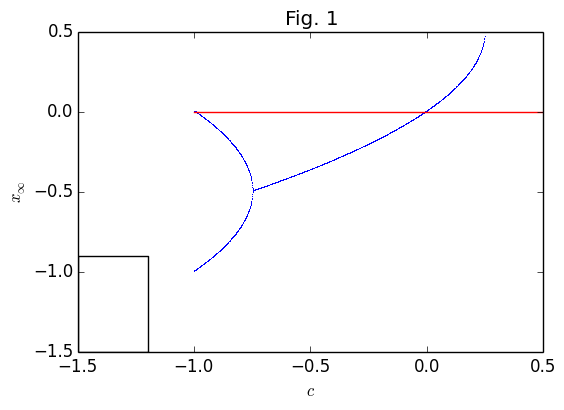

PyObject <matplotlib.text.Text object at 0x3224a0710>

In [10]:
figure(figsize=(6,4))
plot(cc, ff, "b,")
plot([-1.2,-1.5,-1.5,-1.2,-1.2],[-1.5,-1.5,-0.9,-0.9,-1.5], "k-")
plot([-1,0.5],[0.0,0.0], "r-")
xlabel(L"c")
ylabel(L"x_\infty")
title("Fig. 1")

In [46]:
Qc(x,c) = x^2 + c

crange = 0.25:-1/2^10:-1.0

f1 = diagbifurc(Qc, 10000, 2, crange); 
c1 = ones(size(ff)[1])*crange';

In [48]:
function find_one_bif(ff, cc)

    Resta = []
    bif = 0

    for i in 1:length(ff[1,:])

        resta = abs(ff[1, i] - ff[2, i])

        if resta > 0.0001

            bif = i
            break

        end

    end

    bif, cc[1, bif]

end

find_one_bif (generic function with 1 method)

In [50]:
find_one_bif(f1, c1) #funciona! Aunque está bien chafa.

(1025,-0.75)

#### voy a tratar de refinar las orbitas usando métdo de newton

In [56]:
function compute_roots(f, f´,initial_conditions)
    
    roots = similar(initial_conditions)

    for (j, x_0) in enumerate(initial_conditions)
        x = x_0

        # 100 iterations of Newton's method
        for i in 1:100
            x = x - f(x) / f´(x)
        end

        roots[j] = x
    end
    
    roots
end

compute_roots (generic function with 1 method)

In [61]:
roots = compute_roots(x -> (x^2 -0.6)^2 - x - 0.6, x-> 4*x*(x^2 -0.6)-1, -1:0.001:0)

1001-element Array{Float64,1}:
 -0.421954
 -0.421954
 -0.421954
 -0.421954
 -0.421954
 -0.421954
 -0.421954
 -0.421954
 -0.421954
 -0.421954
 -0.421954
 -0.421954
 -0.421954
  ⋮       
 -0.421954
 -0.421954
 -0.421954
 -0.421954
 -0.421954
 -0.421954
 -0.421954
 -0.421954
 -0.421954
 -0.421954
 -0.421954
 -0.421954

Es necesario tener una función que te genera la función iterada en sí misma. Entonces...

### Metaprogramming (cuadrica y más allá...)

In [124]:
nombre(n::Int) = symbol( string("F_", n) )

nombre (generic function with 1 method)

In [128]:
function itera_funcion(n)
    
    x = "x^2 + c"

    for i in 1:n-1

        x = "($x)^2 +c"

    end

    ex = parse(x)
    ex_ret = :( $(nombre(n))(x, c) = $ex )
    ex_ret
end 

itera_funcion (generic function with 1 method)

In [132]:
eval(itera_funcion(3))

F_3 (generic function with 1 method)

In [133]:
using DualNumbers

In [149]:
a_dual = Dual(1,1)

1 + 1ɛ

In [135]:
eval(itera_funcion(2))

F_2 (generic function with 1 method)

In [147]:
F_2(a_dual, 1) 

2 + 0ɛ

In [137]:
F_2(x,c) = F_2{}

search: F_2 float64_isvalid float32_isvalid @__FILE__



No documentation found.

`F_2` is a generic `Function`.

```julia
# 1 method for generic function "F_2":
F_2(x, c) at In[128]:12
```


In [139]:
eval(itera_funcion(1))

F_1 (generic function with 1 method)

In [151]:
b = F_1(a_dual, 0.5)

1.5 + 2.0ɛ

In [153]:
realpart(b)

1.5

Funciona con `DualNumbers` y está muy chido!

### Adecuando `compute_roots`

Lo que busco es darle de comer las orbitas de la función de arriba para que la refine

In [173]:
function compute_roots(f::Function, xx, cc)
    
    roots = similar(xx)
    c = cc[1]

    for j in 1:length(xx)
        
        x = Dual(xx[j], xx[j])

        # 100 iterations of Newton's method
        for i in 1:100
            x_2 = realpart(x) - realpart(f(x, c)) / dualpart(f(x, c))
            x = Dual(x_2, x_2)
        end

        roots[j] = realpart(x)
    end
    
    roots
end

compute_roots (generic function with 3 methods)

In [156]:
Qc(x,c) = x^2 + c

crange = -0.75:-1/2^10:-1.0

f1 = diagbifurc(Qc, 10000, 2, crange); 
c1 = ones(size(ff)[1])*crange';

In [168]:
f1[:,1][2]

-0.49290999218222853

In [166]:
length(ve)

2

In [158]:
eval(itera_funcion(2))

F_2 (generic function with 1 method)

In [175]:
compute_roots(F_2, f1[:, 3], c1[:,3])

2-element Array{Float64,1}:
 -25.5426
 -25.3169

In [171]:


F_2()

LoadError: LoadError: MethodError: `F_2` has no method matching F_2(::DualNumbers.Dual{Int64})
Closest candidates are:
  F_2(::Any, !Matched::Any)
while loading In[171], in expression starting on line 1